# 📓 01 - Exploration du dataset Calliar

## 🧭 Objectifs de l’exploration :

- Format des fichiers : type (image, annotation), structure des dossiers.
- Nombre d’échantillons.
- Distribution des classes / types de texte (lettre, mot, phrase).
- Qualité des images : bruit, taille, lisibilité, fond, contraste.
- Exemples visuels.
- Prétraitements potentiellement nécessaires.

## 🧩 1. Imports & Configuration

In [1]:
import os
import json
import unicodedata
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from pathlib import Path
from PIL import Image
import pandas as pd

## 📁 2. Définition des chemins Calliar

In [20]:
base_path = Path("../data/raw/calliar")

json_paths = {
    split: base_path / "dataset" / split for split in ["train", "test", "valid"]
}
img_paths = {
    split: base_path / "dataset_imgs" / split for split in ["train", "test", "valid"]
}
pix2pix_paths = {
    split: base_path / "pix2pix" / split for split in ["train", "test", "valid"]
}

## 📖 3. Fonction d’analyse de JSON de strokes

In [21]:
def load_stroke_json(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    strokes = [(list(obj.keys())[0], list(obj.values())[0]) for obj in data]
    return strokes

## 📊 4. Statistiques sur les caractères et traits

Top caractères les plus fréquents :
[('.', 13016), ('ا', 5447), ('ل', 4598), ('م', 2436), ('ى', 2417), ('ر', 1903), ('ٮ', 1891), ('ں', 1879), ('ه', 1676), ('و', 1657)]


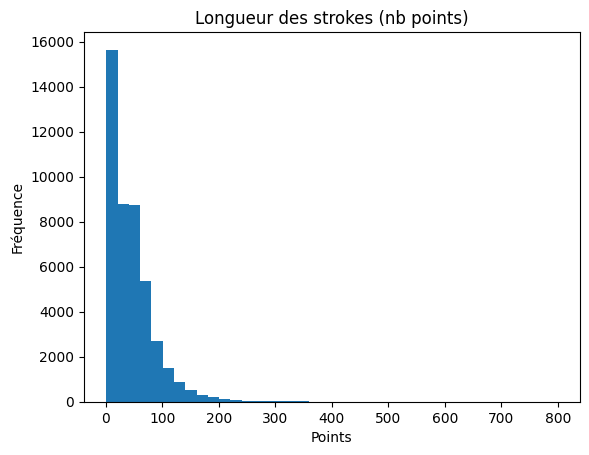

In [23]:
char_counter = Counter()
stroke_lengths = []

for split, folder in json_paths.items():
    for file in folder.glob("*.json"):
        strokes = load_stroke_json(file)
        for char, points in strokes:
            char_counter[char] += 1
            stroke_lengths.append(len(points))

print("Top caractères les plus fréquents :")
print(char_counter.most_common(10))

plt.hist(stroke_lengths, bins=40)
plt.title("Longueur des strokes (nb points)")
plt.xlabel("Points")
plt.ylabel("Fréquence")
plt.show()

## 🎨 5. Visualisation d’un JSON Calligraphié

In [25]:
def plot_strokes(strokes):
    for char, points in strokes:
        points = np.array(points)
        plt.plot(points[:, 0], -points[:, 1], label=char)
    plt.axis('equal')
    plt.legend()
    plt.title("Tracé JSON Calliar")
    plt.show()

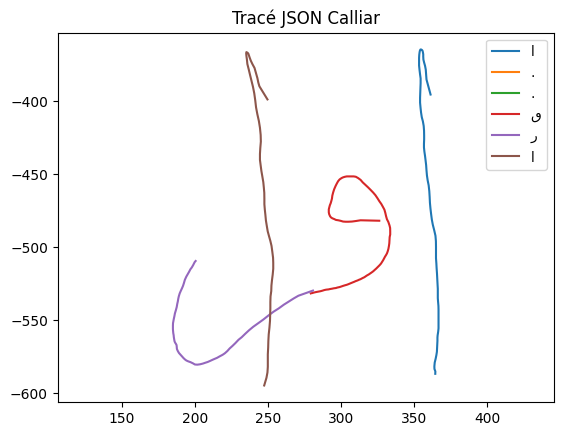

In [26]:

example_file = list(json_paths["train"].glob("*.json"))[0]
example_strokes = load_stroke_json(example_file)
plot_strokes(example_strokes)

## 🖼️ 6. Visualisation d’une image PNG + son texte

In [27]:
def show_image_with_text(img_path):
    text_path = img_path.with_suffix(".txt")
    if not text_path.exists(): return
    with open(text_path, "r", encoding="utf-8") as f:
        text = f.read().strip()
    img = Image.open(img_path)
    plt.imshow(img, cmap='gray')
    plt.title(text)
    plt.axis('off')
    plt.show()

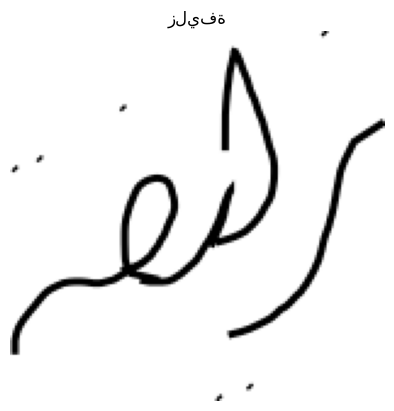

In [28]:

show_image_with_text(img_paths["train"] / "0.png")


## 🔡 7. Détection des doublons sur les noms

In [29]:
from collections import defaultdict

phrase_map = defaultdict(list)

for split, folder in json_paths.items():
    for file in folder.glob("*.json"):
        phrase = file.stem.split("_", 1)[-1]
        phrase_map[phrase].append(file.name)

duplicates = {k: v for k, v in phrase_map.items() if len(v) > 1}
print(f"{len(duplicates)} phrases apparaissent plusieurs fois (variantes calligraphiques)")

51 phrases apparaissent plusieurs fois (variantes calligraphiques)


## 🧮 8. Fréquences des caractères Unicode

In [30]:
def unicode_freq(texts):
    char_counter = Counter()
    for text in texts:
        for c in text:
            char_counter[c] += 1
    return pd.DataFrame(char_counter.items(), columns=["char", "freq"]).sort_values("freq", ascending=False)

# À partir des .txt
all_texts = []
for split, folder in img_paths.items():
    for txt_file in folder.glob("*.txt"):
        with open(txt_file, "r", encoding="utf-8") as f:
            all_texts.append(f.read().strip())

char_freq_df = unicode_freq(all_texts)
display(char_freq_df.head(20))


,char,freq
9,,5038
5,ا,4530
1,ل,4382
7,م,2436
2,ي,2089
14,ن,1879
25,ر,1704
15,و,1626
19,ه,1332
18,ب,1137


## 🧱 9. Extraction du mapping de chars.py

In [32]:
#https:#jrgraphix.net/r/Unicode/0600-06FF
map_chars = {
    "\u0623":["\u0621", "\u0627"], # أ
    "\u0622":["\u0605", "\u0627"], # آ
    "\u0625":["\u0627", "\u0621"], # إ
    "\u0628":["\u066E", "."], # ب
    "\u062A":[".", ".", "\u066E"], # ت
    "\u062B":[".", ".", ".", "\u066E"], # ث 
    "\u062C":["\u062D", "."], # ج
    "\u062E":[".", "\u062D"], # خ
    "\u0630":[".", "\u062F"], # ذ
    "\u0632":[".", "\u0631"], # ز
    "\u0634":[".", ".", ".", "\u0633"], # ش
    "\u0636":[".", "\u0635"], # ض
    "\u0637":["\u0627", "\uFEBB"], # ط
    "\u0638":[".", "\u0627", "\uFEBB"], # ظ
    "\u063A":[".", "\u0639"], # غ
    "\u0641":[".", "\u066F"], # ف
    "\u0642":[".", ".", "\u066F"], # ق
    "\u06A4":[".", ".", ".", "\u066F"], # ڤ
    "\u0643":["\u0621", "\u0644"], # ك
    "\u0646":[".", "\u06BA"], # ن
    "\u0624":["\u0621", "\u0648"], # ؤ
    "\u064A":["\u0649", ".", "."], #ي
    "\u0626":["\u0621", "\u0649"], #ئ
    "\u0629":[".", ".", "\u0647"], #ه
}

# Mapping inverse pour enrichissement
reverse_map = defaultdict(list)
for k, vals in map_chars.items():
    for v in vals:
        reverse_map[v].append(k)
reverse_map

defaultdict(list,
            {'ء': ['أ', 'إ', 'ك', 'ؤ', 'ئ'],
             'ا': ['أ', 'آ', 'إ', 'ط', 'ظ'],
             '\u0605': ['آ'],
             'ٮ': ['ب', 'ت', 'ث'],
             '.': ['ب',
              'ت',
              'ت',
              'ث',
              'ث',
              'ث',
              'ج',
              'خ',
              'ذ',
              'ز',
              'ش',
              'ش',
              'ش',
              'ض',
              'ظ',
              'غ',
              'ف',
              'ق',
              'ق',
              'ڤ',
              'ڤ',
              'ڤ',
              'ن',
              'ي',
              'ي',
              'ة',
              'ة'],
             'ح': ['ج', 'خ'],
             'د': ['ذ'],
             'ر': ['ز'],
             'س': ['ش'],
             'ص': ['ض'],
             'ﺻ': ['ط', 'ظ'],
             'ع': ['غ'],
             'ٯ': ['ف', 'ق', 'ڤ'],
             'ل': ['ك'],
             'ں': ['ن'],
             'و': ['ؤ'],
             

## 🔍 10. Aperçu des fichiers pix2pix

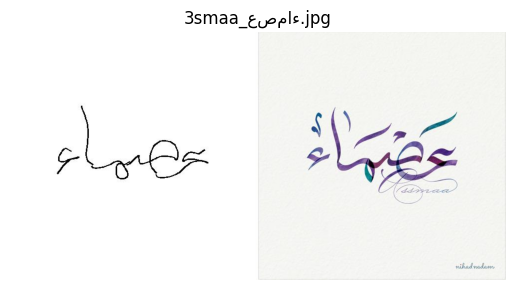

In [33]:
from IPython.display import display

sample = list(pix2pix_paths["train"].glob("*.jpg"))[0]
img = Image.open(sample)
plt.imshow(img)
plt.title(sample.name)
plt.axis('off')
plt.show()